In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from PIL import Image

from tensorflow import keras
from tensorflow.keras import layers
from scipy.signal import wiener

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
from umap import UMAP

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import (
    VGG16, VGG19, ResNet50, InceptionV3, Xception, MobileNetV2, 
    DenseNet121, EfficientNetB0, InceptionResNetV2
)
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, Average
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision

2025-07-30 02:22:27.544088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753842147.763800      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753842147.832447      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# --- 1. CONFIGURATION AND SETUP ---

# --- Dataset and Output Paths ---

In [3]:
SOURCE_DIR = '/kaggle/input/fracatlas/FracAtlas/images'
BASE_DIR = '/kaggle/working/bone_fracture_dataset_final'
OUTPUT_DIR = '/kaggle/working/model_outputs'

# --- Model and Training Parameters ---

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
NUM_CLASSES = 1 
EPOCHS = 25
EARLY_STOPPING_PATIENCE = 10


# --- Preprocessing Toggles ---

In [5]:
APPLY_SEGMENTATION = False
APPLY_CLAHE = False
APPLY_GAUSSIAN_BLUR = False 
APPLY_MEDIAN_FILTER = False
APPLY_WIENER_FILTER = False
APPLY_HISTOGRAM_EQUALIZATION = False
APPLY_LAPLACIAN_FILTER = False
APPLY_AVERAGE_FILTER = False
APPLY_SOBEL_FILTER = False
APPLY_CANNY_FILTER = False

In [6]:
def setup_directories():
    
    if os.path.exists(BASE_DIR):
        print(f"Directory '{BASE_DIR}' already exists. Deleting it to recreate...")
        shutil.rmtree(BASE_DIR)
    
    print("Creating new train/val/test directories...")
    train_dir = os.path.join(BASE_DIR, 'train')
    val_dir = os.path.join(BASE_DIR, 'val')
    test_dir = os.path.join(BASE_DIR, 'test')
    
    os.makedirs(train_dir)
    os.makedirs(val_dir)
    os.makedirs(test_dir)
    os.makedirs(OUTPUT_DIR, exist_ok=True)

    try:
        class_names = [
            d for d in os.listdir(SOURCE_DIR)
            if os.path.isdir(os.path.join(SOURCE_DIR, d))
        ]
        
        print(class_names)
        print(f"Found {len(class_names)} matching class directories to process.")

        for class_name in class_names:
            print(f"Processing '{class_name}'...")
            
            for d in [train_dir, val_dir, test_dir]:
                os.makedirs(os.path.join(d, class_name), exist_ok=True)
            
            src_path = os.path.join(SOURCE_DIR, class_name)
            all_files = [f for f in os.listdir(src_path) if os.path.isfile(os.path.join(src_path, f))]

            # --- Start: New code to verify images and filter out corrupted ones --- a_id=2
            valid_files = []
            print(f"Verifying {len(all_files)} images in '{class_name}'...")
            for f in all_files:
                # Process only common image file types
                if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    image_path = os.path.join(src_path, f)
                    try:
                        # Attempt to open and load the image
                        img = Image.open(image_path)
                        img.load() 
                        # If successful, add to the list of valid files
                        valid_files.append(f)
                    except (IOError, OSError) as e:
                        # If an error occurs, the image is likely corrupted
                        print(f"  - Corrupted image skipped: {f} (Reason: {e})")
                else:
                    print(f"  - Skipped non-image file: {f}")

            print(f"Found {len(valid_files)} valid images in '{class_name}'.")
            # --- End: New code --- a_id=3

            # Shuffle and split the list of *valid* files
            np.random.shuffle(valid_files)
            
            train_split, val_split = 0.7, 0.15
            train_end = int(len(valid_files) * train_split)
            val_end = train_end + int(len(valid_files) * val_split)
            # Use the filtered 'valid_files' list for splitting
            train_files, val_files, test_files = valid_files[:train_end], valid_files[train_end:val_end], valid_files[val_end:]
            
            # Copy valid files into the correctly named directories
            for f in train_files:
                shutil.copy(os.path.join(src_path, f), os.path.join(train_dir, class_name, f))
            for f in val_files:
                shutil.copy(os.path.join(src_path, f), os.path.join(val_dir, class_name, f))
            for f in test_files:
                shutil.copy(os.path.join(src_path, f), os.path.join(test_dir, class_name, f))

        print("\nData splitting and directory setup complete.")
        print(f"Dataset created at: '{BASE_DIR}'")

    except FileNotFoundError:
        print(f"ERROR: Source directory not found at '{SOURCE_DIR}'. Please check the path.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

# --- Run the Setup ---
setup_directories()

# You can now use these variables to point to your new dataset
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'val')
test_dir = os.path.join(BASE_DIR, 'test')

Creating new train/val/test directories...
['Non_fractured', 'Fractured']
Found 2 matching class directories to process.
Processing 'Non_fractured'...
Verifying 3366 images in 'Non_fractured'...
  - Corrupted image skipped: IMG0004347.jpg (Reason: image file is truncated (40 bytes not processed))
  - Corrupted image skipped: IMG0004297.jpg (Reason: image file is truncated (5 bytes not processed))
  - Corrupted image skipped: IMG0004148.jpg (Reason: image file is truncated (14 bytes not processed))
  - Corrupted image skipped: IMG0004177.jpg (Reason: image file is truncated (34 bytes not processed))
  - Corrupted image skipped: IMG0004291.jpg (Reason: image file is truncated (13 bytes not processed))
  - Corrupted image skipped: IMG0004290.jpg (Reason: image file is truncated (54 bytes not processed))
  - Corrupted image skipped: IMG0004288.jpg (Reason: image file is truncated (1 bytes not processed))
  - Corrupted image skipped: IMG0004263.jpg (Reason: image file is truncated (24 bytes

# --- 2. PREPROCESSING FUNCTIONS ---

In [7]:
def apply_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)    
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    segmented_image = cv2.bitwise_and(image, image, mask=mask)
    return segmented_image

def apply_clahe(image):
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab_image)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged_channels = cv2.merge([cl, a, b])
    return cv2.cvtColor(merged_channels, cv2.COLOR_LAB2RGB)

def apply_gaussian_blur(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def apply_median_blur(image):
    return cv2.medianBlur(image, 5)

def apply_wiener_filter(image):
    img_float = image.astype(np.float64) / 255.0
    filtered_channels = [wiener(channel) for channel in cv2.split(img_float)]
    filtered_image = cv2.merge(filtered_channels)
    return (np.clip(filtered_image, 0, 1) * 255).astype(np.uint8)

def apply_histogram_equalization(image):
    img_ycrcb = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    img_ycrcb[:, :, 0] = cv2.equalizeHist(img_ycrcb[:, :, 0])
    return cv2.cvtColor(img_ycrcb, cv2.COLOR_YCrCb2RGB)

def apply_laplacian_filter(image):
    laplacian = cv2.Laplacian(image, cv2.CV_64F)
    abs_laplacian = np.absolute(laplacian)
    return np.uint8(abs_laplacian)

def apply_average_filter(image):
    return cv2.blur(image, (5, 5))

def apply_sobel_filter(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    sobel_combined = np.sqrt(sobelx**2 + sobely**2)
    sobel_norm = cv2.normalize(sobel_combined, None, 0, 255, cv2.NORM_MINMAX)
    sobel_uint8 = np.uint8(sobel_norm)
    return cv2.cvtColor(sobel_uint8, cv2.COLOR_GRAY2RGB)

def apply_canny_filter(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, threshold1=100, threshold2=200)
    return cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)

def get_preprocessing_function(model_specific_preprocess_input):
    def master_preprocessing_function(image):
        if model_specific_preprocess_input is None:
            return image / 255.0
            
        processed_image = image.astype('uint8')
        if APPLY_SEGMENTATION: processed_image = apply_segmentation(processed_image)
        if APPLY_WIENER_FILTER: processed_image = apply_wiener_filter(processed_image)
        if APPLY_MEDIAN_FILTER: processed_image = apply_median_blur(processed_image)
        if APPLY_AVERAGE_FILTER: processed_image = apply_average_filter(processed_image)
        if APPLY_GAUSSIAN_BLUR: processed_image = apply_gaussian_blur(processed_image)
        if APPLY_CLAHE: processed_image = apply_clahe(processed_image)
        if APPLY_HISTOGRAM_EQUALIZATION: processed_image = apply_histogram_equalization(processed_image)
        if APPLY_LAPLACIAN_FILTER: processed_image = apply_laplacian_filter(processed_image)
        if APPLY_SOBEL_FILTER: processed_image = apply_sobel_filter(processed_image)
        if APPLY_CANNY_FILTER: processed_image = apply_canny_filter(processed_image)
        processed_image = processed_image.astype('float32')
        return model_specific_preprocess_input(processed_image)
    return master_preprocessing_function

# --- Function to Create the Custom CNN Model ---

In [8]:
def create_custom_cnn(input_shape, num_classes):
    """Builds and returns the user-defined custom CNN model."""
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16, (1, 1), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(3, 3),
        layers.Conv2D(32, (1, 1), activation='relu'),
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(3, 3),
        layers.Conv2D(64, (1, 1), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (5, 5), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(3, 3),
        layers.Conv2D(16, (1, 1), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(16, (5, 5), activation='relu'),
        layers.BatchNormalization(),
        # Add a feature extractor layer name for Grad-CAM and feature projection
        layers.GlobalAveragePooling2D(name='feature_extractor_layer'),
        layers.Dense(num_classes, activation='sigmoid')
    ])
    print("--- Custom CNN Model Summary ---")
    model.summary()
    return model

# --- 3. VISUALIZATION AND REPORTING FUNCTIONS ---

In [9]:
def plot_training_history(history, model_name, save_dir):
    """Plots accuracy, loss, and precision from the model's history."""
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    metrics = ['accuracy', 'loss', 'precision']
    for i, metric in enumerate(metrics):
        val_metric = f'val_{metric}'
        axes[i].plot(history.history[metric], label=f'Train {metric.capitalize()}')
        axes[i].plot(history.history[val_metric], label=f'Validation {metric.capitalize()}')
        axes[i].set_title(f'{model_name} - {metric.capitalize()}')
        axes[i].legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{model_name}_training_history.png'))
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names, model_name, save_dir):
    """Plots a confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(os.path.join(save_dir, f'{model_name}_confusion_matrix.png'))
    plt.show()

def plot_roc_pr_curves(y_true, y_pred_prob, model_name, save_dir):
    """Plots ROC and Precision-Recall curves, simplified for binary classification."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0].set_title(f'{model_name} - ROC Curve'); axes[0].legend(loc="lower right")

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    pr_auc = auc(recall, precision)
    axes[1].plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {pr_auc:.2f})')
    axes[1].set_title(f'{model_name} - Precision-Recall Curve'); axes[1].legend(loc="lower left")

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{model_name}_roc_pr_curves.png'))
    plt.show()

def plot_projections(features, labels, class_names, model_name, save_dir):
    """Plots t-SNE and UMAP projections of features."""
    fig, axes = plt.subplots(1, 2, figsize=(18, 7))
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(features)-1)).fit_transform(features)
    df_tsne = pd.DataFrame({'x': tsne[:, 0], 'y': tsne[:, 1], 'label': [class_names[l] for l in labels]})
    sns.scatterplot(data=df_tsne, x='x', y='y', hue='label', ax=axes[0], palette='viridis').set_title(f'{model_name} - t-SNE')
    
    umap_proj = UMAP(n_neighbors=15, min_dist=0.1, random_state=42).fit_transform(features)
    df_umap = pd.DataFrame({'x': umap_proj[:, 0], 'y': umap_proj[:, 1], 'label': [class_names[l] for l in labels]})
    sns.scatterplot(data=df_umap, x='x', y='y', hue='label', ax=axes[1], palette='viridis').set_title(f'{model_name} - UMAP')
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f'{model_name}_projections.png'))
    plt.show()

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    """Creates a Grad-CAM heatmap."""
    grad_model = Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        # For binary with sigmoid, the class channel is the output itself.
        class_channel = preds
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = last_conv_layer_output[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.4):
    """Saves a superimposed Grad-CAM image."""
    img = cv2.imread(img_path); img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0])); heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.clip(heatmap * alpha + img, 0, 255).astype('uint8')
    cv2.imwrite(cam_path, superimposed_img)

def visualize_class_maps(model, last_conv_layer_name, preprocessor, model_name, save_dir, test_dir_path):
    """Displays Grad-CAM for one sample from each class in a 1xN layout."""
    class_names = sorted(os.listdir(test_dir_path))
    plt.figure(figsize=(12, 6))
    for i, class_name in enumerate(class_names):
        img_path = os.path.join(test_dir_path, class_name, os.listdir(os.path.join(test_dir_path, class_name))[0])
        img_array = img_to_array(load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)))
        img_preprocessed = preprocessor(img_array.copy()) if preprocessor else img_array / 255.0
        img_for_model = np.expand_dims(img_preprocessed, axis=0)
        heatmap = make_gradcam_heatmap(img_for_model, model, last_conv_layer_name)
        cam_path = os.path.join(save_dir, f'{model_name}_gradcam_{class_name}.png')
        save_and_display_gradcam(img_path, heatmap, cam_path)
        ax = plt.subplot(1, len(class_names), i + 1)
        ax.imshow(cv2.cvtColor(cv2.imread(cam_path), cv2.COLOR_BGR2RGB)); ax.set_title(f'Grad-CAM: {class_name}'); ax.axis("off")
    plt.tight_layout(); plt.show()

def visualize_predictions(y_true, y_pred, test_generator, class_names, model_name, save_dir, num_examples_per_class=2):
    """Shows sample predictions, highlighting correct and incorrect ones."""
    filenames = test_generator.filenames
    examples_shown = {name: 0 for name in class_names}
    fig, axes = plt.subplots(nrows=num_examples_per_class, ncols=len(class_names), figsize=(18, 5 * num_examples_per_class), squeeze=False)
    fig.suptitle(f'{model_name} - Prediction Samples', fontsize=20)
    for i in range(len(filenames)):
        if all(v >= num_examples_per_class for v in examples_shown.values()): break
        true_label_idx = y_true[i]
        true_label_name = class_names[true_label_idx]
        if examples_shown[true_label_name] < num_examples_per_class:
            img_path = os.path.join(test_generator.directory, filenames[i])
            ax = axes[examples_shown[true_label_name], true_label_idx]
            ax.imshow(load_img(img_path))
            ax.axis('off')
            title_color = 'green' if y_pred[i] == true_label_idx else 'red'
            ax.set_title(f"True: {true_label_name}\nPred: {class_names[y_pred[i]]}", color=title_color)
            examples_shown[true_label_name] += 1
    fig.tight_layout(rect=[0, 0, 1, 0.96]); plt.savefig(os.path.join(save_dir, f'{model_name}_prediction_samples.png')); plt.show()

# --- 4. MAIN TRAINING & EVALUATION LOOP ---

 # --- Evaluation & Visualization ---


========================= Training and Evaluating: CustomCNN =========================
Found 2815 images belonging to 2 classes.
Found 603 images belonging to 2 classes.
Found 606 images belonging to 2 classes.
--- Custom CNN Model Summary ---


2025-07-30 02:24:14.977609: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 74, 74, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 72, 72, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 20, 20, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 6, 6, 16)       │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 6, 6, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 2, 2, 16)       │         6,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2, 2, 16)       │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_extractor_layer         │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,737 (479.44 KB)

 Trainable params: 122,321 (477.82 KB)

 Non-trainable params: 416 (1.62 KB)

88/88 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5154 - loss: 0.7684 - precision: 0.8394 - val_accuracy: 0.1791 - val_loss: 0.7451 - val_precision: 1.0000

--- Loading best model from '/kaggle/working/model_outputs/CustomCNN/CustomCNN_best.keras' for evaluation ---


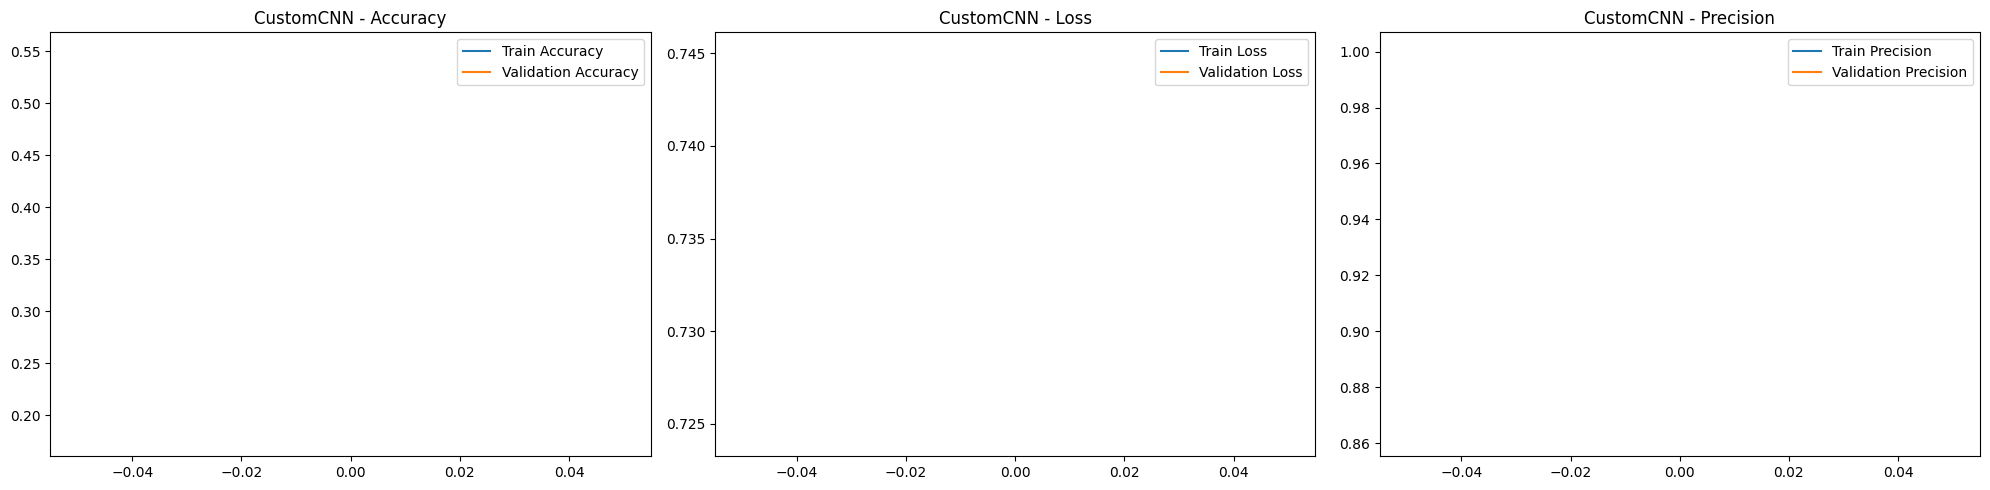

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step

Classification Report for CustomCNN:
               precision    recall  f1-score   support

    Fractured       0.18      1.00      0.30       109
Non_fractured       0.00      0.00      0.00       497

     accuracy                           0.18       606
    macro avg       0.09      0.50      0.15       606
 weighted avg       0.03      0.18      0.05       606



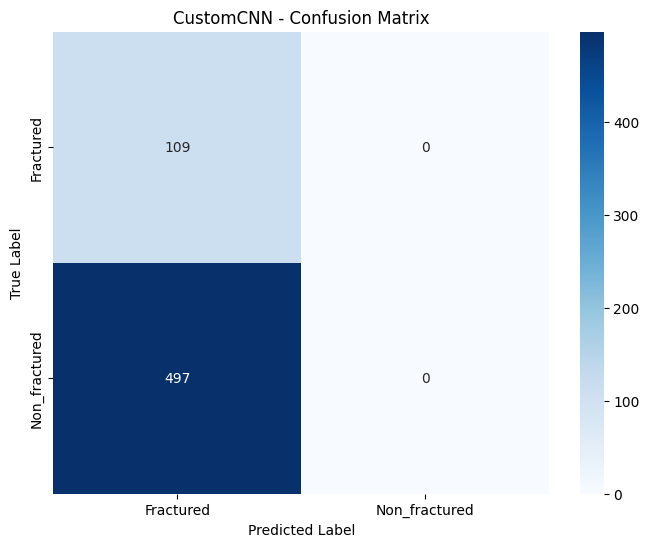

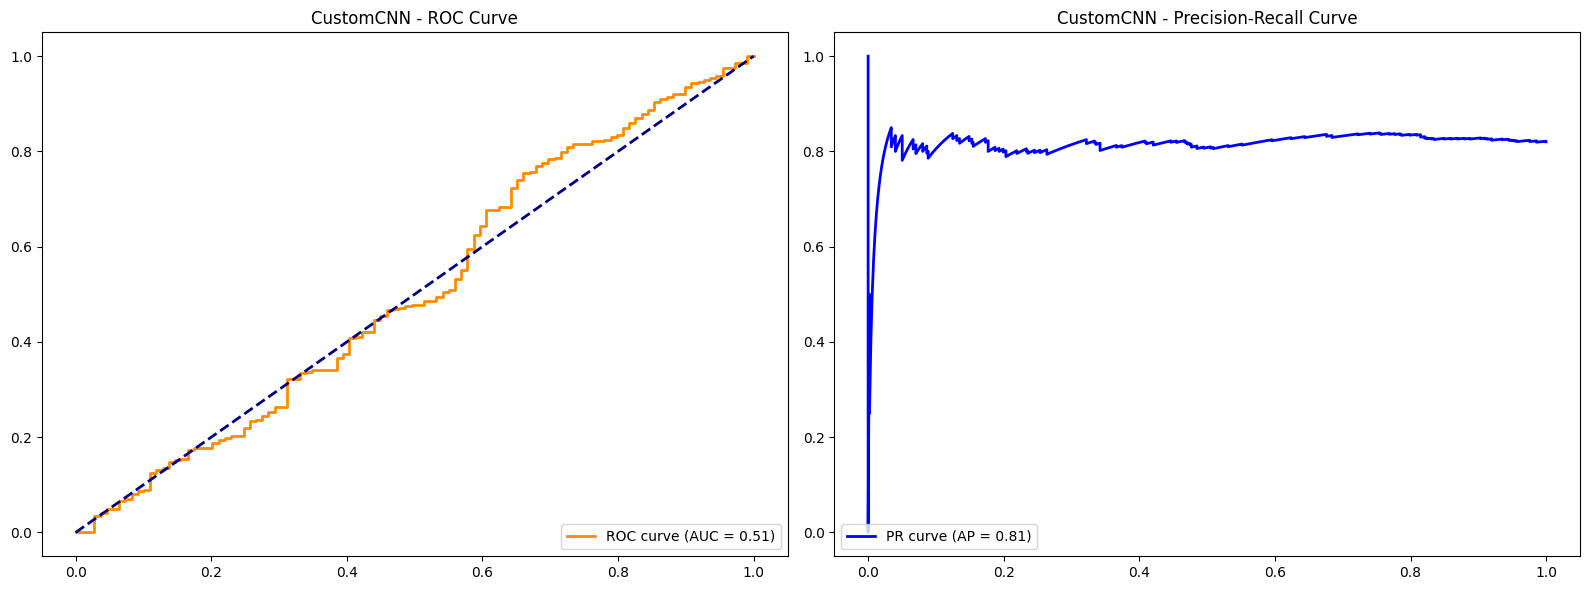

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 342ms/step


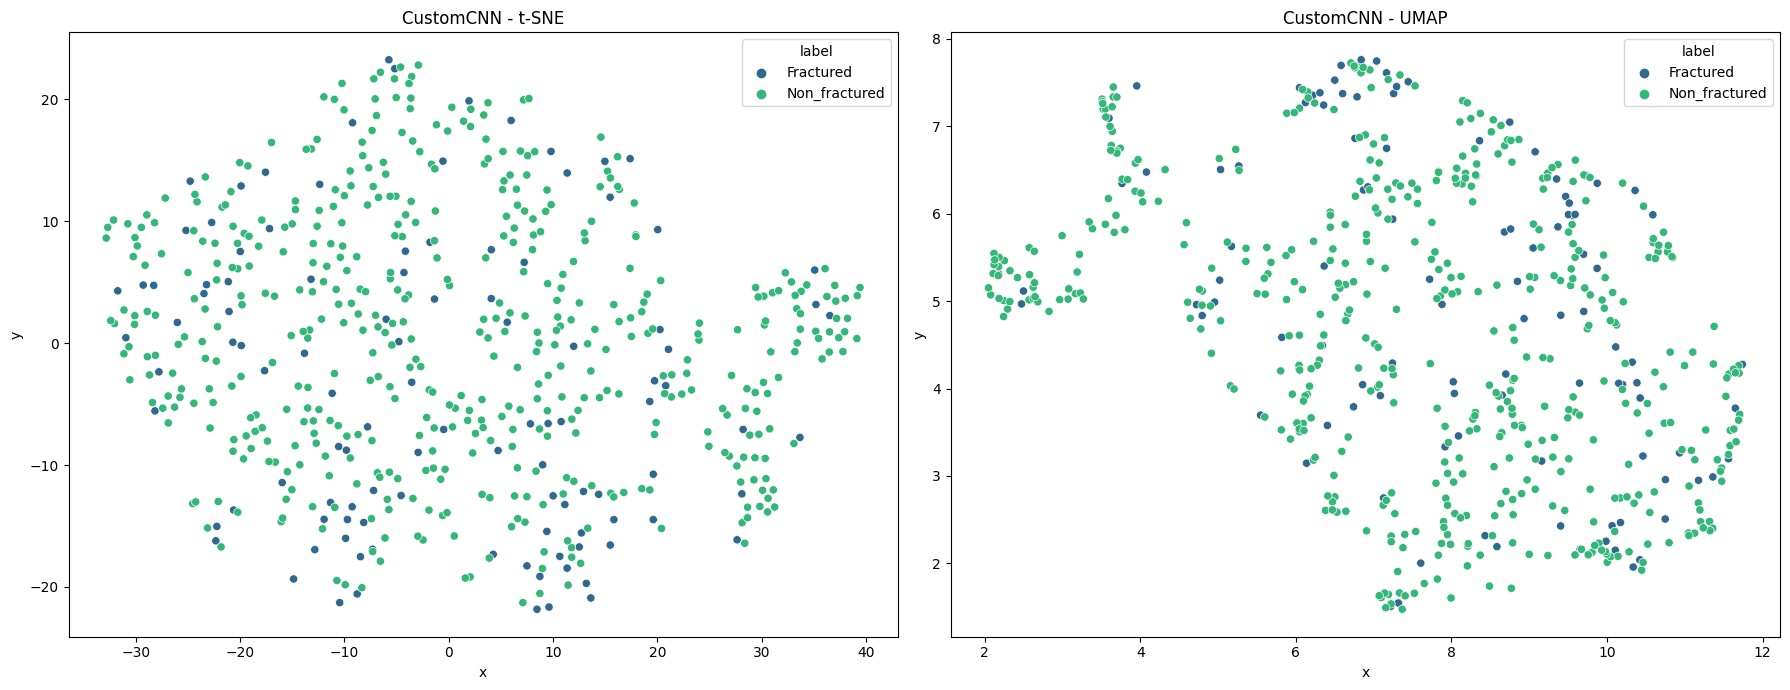

Skipping Grad-CAM visualization for CustomCNN.


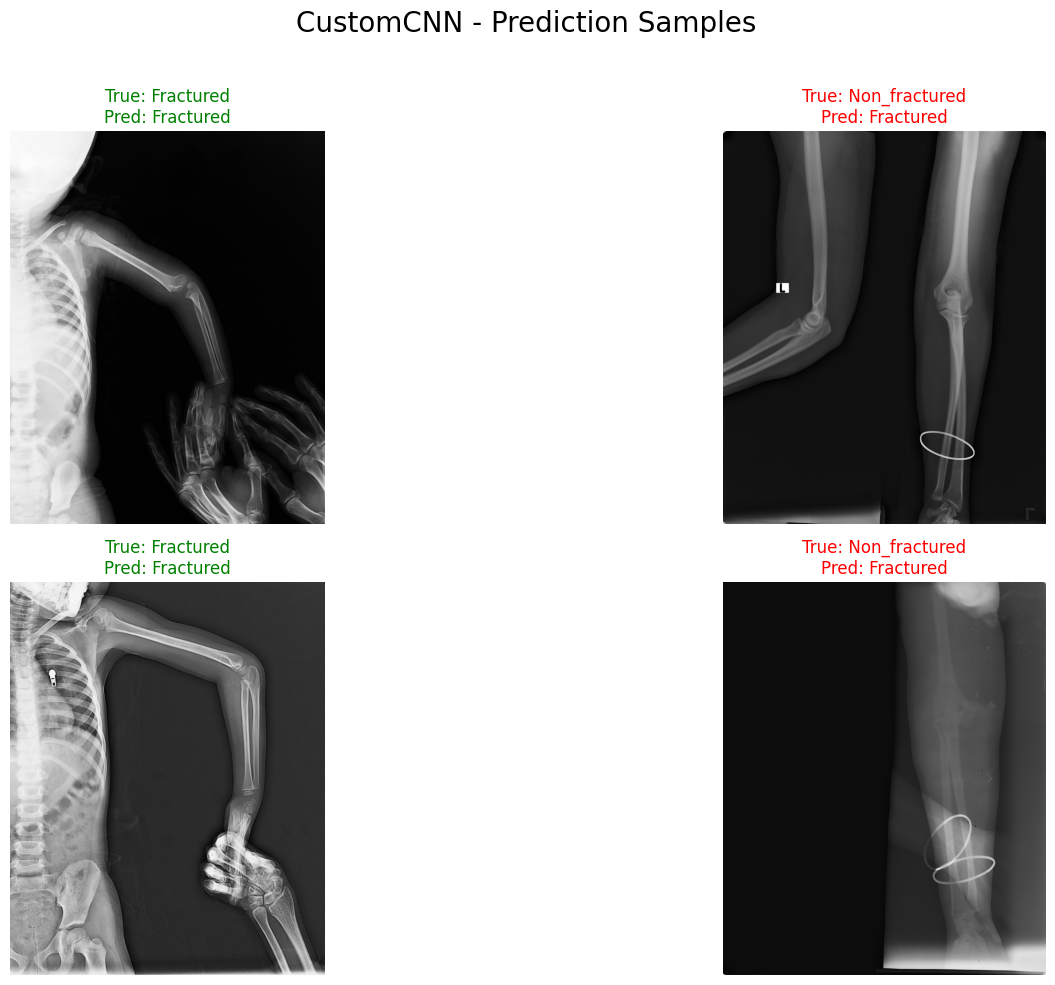


Finished processing CustomCNN. Results saved to /kaggle/working/model_outputs/CustomCNN

========================= Training and Evaluating: VGG16 =========================
Found 2815 images belonging to 2 classes.
Found 603 images belonging to 2 classes.
Found 606 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
 3/88 ━━━━━━━━━━━━━━━━━━━━ 11:28 8s/step - accuracy: 0.4444 - loss: 1.7345 - precision: 0.9389

In [ ]:
# --- Model Registry ---
MODELS = {
    'CustomCNN': (None, None),
    'VGG16': (VGG16, tf.keras.applications.vgg16.preprocess_input),
    'VGG19': (VGG19, tf.keras.applications.vgg19.preprocess_input),
    'ResNet50': (ResNet50, tf.keras.applications.resnet50.preprocess_input),
    'InceptionV3': (InceptionV3, tf.keras.applications.inception_v3.preprocess_input),
    'Xception': (Xception, tf.keras.applications.xception.preprocess_input),
    'MobileNetV2': (MobileNetV2, tf.keras.applications.mobilenet_v2.preprocess_input),
    'DenseNet121': (DenseNet121, tf.keras.applications.densenet.preprocess_input),
    'EfficientNetB0': (EfficientNetB0, tf.keras.applications.efficientnet.preprocess_input),
    'InceptionResNetV2': (InceptionResNetV2, tf.keras.applications.inception_resnet_v2.preprocess_input),
}

# Main Training and Evaluation Loop
for model_name, (model_constructor, preprocess_input) in MODELS.items():
    print(f"\n{'='*25} Training and Evaluating: {model_name} {'='*25}")
    model_save_dir = os.path.join(OUTPUT_DIR, model_name)
    os.makedirs(model_save_dir, exist_ok=True)
    
    # Data Generators
    if model_name == 'CustomCNN':
        train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
        val_test_datagen = ImageDataGenerator(rescale=1./255)
    else:
        train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
        val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_generator = train_datagen.flow_from_directory(train_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='binary')
    validation_generator = val_test_datagen.flow_from_directory(val_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='binary')
    test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, class_mode='binary', shuffle=False)
    
    # Model Building
    if model_name == 'CustomCNN':
        model = create_custom_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES)
    else:
        base_model = model_constructor(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
        base_model.trainable = False
        x = GlobalAveragePooling2D(name='feature_extractor_layer')(base_model.output)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.5)(x)
        predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)
        model = Model(inputs=base_model.input, outputs=predictions)
    
    # Model Training
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision')])
    best_model_path = os.path.join(model_save_dir, f'{model_name}_best.keras')
    callbacks = [
        EarlyStopping(monitor='val_accuracy', patience=EARLY_STOPPING_PATIENCE, restore_best_weights=True),
        ModelCheckpoint(filepath=best_model_path, save_best_only=True, monitor='val_accuracy')
    ]
    history = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator, callbacks=callbacks)
    
    # Evaluation & Visualization
    print(f"\n--- Loading best model from '{best_model_path}' for evaluation ---")
    model = tf.keras.models.load_model(best_model_path)
    
    plot_training_history(history, model_name, model_save_dir)
    
    y_pred_prob = model.predict(test_generator).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)
    y_true = test_generator.classes
    class_names = list(test_generator.class_indices.keys())
    
    print(f'\nClassification Report for {model_name}:\n{classification_report(y_true, y_pred, target_names=class_names)}')
    plot_confusion_matrix(y_true, y_pred, class_names, model_name, model_save_dir)
    plot_roc_pr_curves(y_true, y_pred_prob, model_name, model_save_dir)
    
    # Feature Projection Visualization
    feature_extractor = Model(inputs=model.inputs, outputs=model.get_layer('feature_extractor_layer').output)
    test_features = feature_extractor.predict(test_generator)
    plot_projections(test_features, y_true, class_names, model_name, model_save_dir)
    
    # --- KEY CHANGE: Grad-CAM Visualization Skipped for CustomCNN ---
    last_conv_layer_name = next((layer.name for layer in reversed(model.layers) if 'conv' in layer.name.lower()), None)
    
    # Only run Grad-CAM if a conv layer is found AND the model is NOT the CustomCNN
    if last_conv_layer_name and model_name != 'CustomCNN':
        print(f"Generating Grad-CAM for {model_name} using layer: {last_conv_layer_name}")
        preprocessor = preprocess_input
        visualize_class_maps(model, last_conv_layer_name, preprocessor, model_name, model_save_dir, test_dir)
    else:
        # This will now be triggered for CustomCNN or if no conv layer is found
        print(f"Skipping Grad-CAM visualization for {model_name}.")
    
    # Prediction Visualization
    visualize_predictions(y_true, y_pred, test_generator, class_names, model_name, model_save_dir)

    print(f"\nFinished processing {model_name}. Results saved to {model_save_dir}")

print("\nAll models have been trained and evaluated.")


In [ ]:
def evaluate_ensemble(ensemble_model_names, ensemble_name):
    """
    Loads a list of binary classification models, averages their predictions, 
    and evaluates the resulting ensemble.
    """
    print(f"\n{'='*20} Creating and Evaluating Ensemble: {ensemble_name} {'='*20}")
    
    all_preds_prob = []
    y_true_ensemble = None
    class_names_ensemble = None

    for model_name in ensemble_model_names:
        print(f"--- Loading model: {model_name} for ensembling ---")
        
        # Get the preprocessing function from the MODELS dictionary
        _ , preprocess_input = MODELS.get(model_name, (None, None))
        
        model_path = os.path.join(OUTPUT_DIR, model_name, f'{model_name}_best.keras')
        if not os.path.exists(model_path):
            print(f"Warning: Model file not found for {model_name} at {model_path}. Skipping.")
            continue
        
        model = tf.keras.models.load_model(model_path)
        
        # Define the appropriate data generator for the model
        if model_name == 'CustomCNN':
             test_datagen = ImageDataGenerator(rescale=1./255)
        else:
             test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

        # CHANGE 1: Use `class_mode='binary'` for the generator
        test_generator_ensemble = test_datagen.flow_from_directory(
            test_dir, 
            target_size=(IMG_HEIGHT, IMG_WIDTH), 
            batch_size=BATCH_SIZE,
            class_mode='binary',  # Corrected for binary classification
            shuffle=False
        )
        
        # Get the ground truth labels and class names only once
        if y_true_ensemble is None:
            y_true_ensemble = test_generator_ensemble.classes
            class_names_ensemble = list(test_generator_ensemble.class_indices.keys())
            
        # CHANGE 2: Get predictions and flatten them for binary output
        # model.predict() will return shape (n_samples, 1), so we flatten it
        preds_prob = model.predict(test_generator_ensemble).flatten()
        all_preds_prob.append(preds_prob)

    if len(all_preds_prob) < 2:
        print(f"Could not create ensemble '{ensemble_name}' because fewer than 2 valid models were found.")
        return

    print(f"\n--- Averaging predictions for '{ensemble_name}' ---")
    
    # CHANGE 3: Average probabilities and determine class prediction via threshold
    ensemble_preds_prob = np.mean(all_preds_prob, axis=0)
    ensemble_y_pred = (ensemble_preds_prob > 0.5).astype(int) # Use 0.5 threshold

    # Create a directory to save ensemble results
    ensemble_save_dir = os.path.join(OUTPUT_DIR, ensemble_name.replace(" ", "_").lower())
    os.makedirs(ensemble_save_dir, exist_ok=True)

    # --- Evaluation ---
    print(f'\nClassification Report for {ensemble_name}:\n{classification_report(y_true_ensemble, ensemble_y_pred, target_names=class_names_ensemble)}')
    
    # Plotting functions
    plot_confusion_matrix(y_true_ensemble, ensemble_y_pred, class_names_ensemble, ensemble_name, ensemble_save_dir)
    
    # CHANGE 4: Call plot_roc_pr_curves with the correct 4 arguments
    plot_roc_pr_curves(y_true_ensemble, ensemble_preds_prob, ensemble_name, ensemble_save_dir)
    
    print(f"\nFinished processing {ensemble_name}. Results saved to {ensemble_save_dir}")

# --- Define and run hard-coded ensembles ---

In [ ]:
# Ensemble of 2 models
evaluate_ensemble(['VGG16', 'EfficientNetB0'], "Ensemble of 2 (VGG16, EfficientNetB0)")
evaluate_ensemble(['VGG19', 'EfficientNetB0'], "Ensemble of 2 (VGG19, EfficientNetB0)")
evaluate_ensemble(['ResNet50', 'EfficientNetB0'], "Ensemble of 2 (ResNet50, EfficientNetB0)")
evaluate_ensemble(['MobileNetV2', 'EfficientNetB0'], "Ensemble of 2 (MobileNetV2, EfficientNetB0)")
evaluate_ensemble(['ResNet50', 'MobileNetV2'], "Ensemble of 2 (ResNet50, MobileNetV2)")
evaluate_ensemble(['Xception', 'MobileNetV2'], "Ensemble of 2 (Xception, MobileNetV2)")
evaluate_ensemble(['EfficientNetB0', 'Xception'], "Ensemble of 2 (EfficientNetB0, Xception)")
evaluate_ensemble(['DenseNet121', 'EfficientNetB0'], "Ensemble of 2 (DenseNet121, EfficientNetB0)")

# Ensemble of 3 models
evaluate_ensemble(['VGG19', 'EfficientNetB0', 'InceptionV3'], "Ensemble of 3 (VGG19, EfficientNetB0, InceptionV3)")
evaluate_ensemble(['MobileNetV2', 'EfficientNetB0', 'InceptionV3'], "Ensemble of 3 (MobileNetV2, EfficientNetB0, InceptionV3)")
evaluate_ensemble(['DenseNet121', 'EfficientNetB0', 'MobileNetV2'], "Ensemble of 3 (DenseNet121, EfficientNetB0, MobileNetV2)")
evaluate_ensemble(['EfficientNetB0', 'VGG19', 'MobileNetV2'], "Ensemble of 3 (EfficientNetB0, VGG19, MobileNetV2)")